# EE5176 Programming Assignment 1: Image Denoising

This notebook implements the Image Denoising section using bilateral filtering for noise reduction.
The bilateral filter is controlled by two parameters σs and σr where:
- σs controls the spatial weighing (spatial extent of the kernel)
- σr controls the alignment of image intensities (range kernel parameter)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from skimage import color
import cv2
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## Bilateral Filter Implementation

Since the original assignment provides bfilter2.m, I'll implement a Python equivalent based on the bilateral filtering principles.

In [2]:
def bilateral_filter(image, w, sigma_spatial, sigma_range):
    """
    Apply bilateral filter to an image
    
    Parameters:
    - image: input image (H x W x C) where C can be 1 or 3
    - w: half-size of the bilateral filter window
    - sigma_spatial: spatial domain standard deviation (σs)
    - sigma_range: intensity domain standard deviation (σr)
    
    Returns:
    - filtered_image: bilateral filtered image
    """
    
    # Ensure image is in range [0,1] for bilateral filtering
    if image.max() > 1.0:
        image = image.astype(np.float64) / 255.0
    
    # Handle grayscale or color images
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=2)
    
    h, width, channels = image.shape
    filtered_image = np.zeros_like(image)
    
    # Pre-compute Gaussian spatial weights
    x, y = np.meshgrid(np.arange(-w, w+1), np.arange(-w, w+1))
    spatial_weights = np.exp(-(x**2 + y**2) / (2 * sigma_spatial**2))
    
    print(f"Applying bilateral filter (w={w}, σs={sigma_spatial:.2f}, σr={sigma_range:.3f})...")
    
    # Apply bilateral filter
    for c in range(channels):
        for i in range(h):
            if i % 100 == 0:
                print(f"Processing row {i}/{h} for channel {c+1}/{channels}")
            
            for j in range(width):
                # Extract local region
                i_min = max(i - w, 0)
                i_max = min(i + w + 1, h)
                j_min = max(j - w, 0)
                j_max = min(j + w + 1, width)
                
                # Get local patch
                local_patch = image[i_min:i_max, j_min:j_max, c]
                
                # Compute intensity weights (range weights)
                intensity_diff = local_patch - image[i, j, c]
                range_weights = np.exp(-(intensity_diff**2) / (2 * sigma_range**2))
                
                # Get corresponding spatial weights
                spatial_region = spatial_weights[(i_min-i+w):(i_max-i+w), (j_min-j+w):(j_max-j+w)]
                
                # Combine weights
                combined_weights = range_weights * spatial_region
                
                # Normalize and compute filtered value
                weight_sum = np.sum(combined_weights)
                if weight_sum > 0:
                    filtered_image[i, j, c] = np.sum(combined_weights * local_patch) / weight_sum
                else:
                    filtered_image[i, j, c] = image[i, j, c]
    
    return filtered_image.squeeze() if channels == 1 else filtered_image

## Demosaicing Function

Using OpenCV built-in demosaicing as in the white balancing notebook.

In [4]:
def demosaic_builtin(raw_image, cfa_pattern):
    """Demosaic raw image using OpenCV built-in function"""
    # Normalize and convert to uint8 if necessary for OpenCV
    raw_conv = raw_image.copy()
    if raw_conv.dtype != np.uint8:
        raw_conv = np.clip(raw_conv, 0, 255).astype(np.uint8)
    
    # Select OpenCV color code based on CFA
    if cfa_pattern == 'RGGB':
        code = cv2.COLOR_BAYER_RG2RGB
    elif cfa_pattern == 'GRBG':
        code = cv2.COLOR_BAYER_GR2RGB
    else:
        raise ValueError(f'Unsupported CFA pattern: {cfa_pattern}')
    
    # Perform demosaicing using OpenCV builtin
    rgb_img = cv2.cvtColor(raw_conv, code)
    return rgb_img

## Load and Demosaic Raw Images

Load all three raw images and their corresponding Bayer patterns, then demosaic them.

In [5]:
# Load RAW images and patterns
images_info = {
    'Raw_image1': {
        'raw_file': 'Copy of RawImage1.mat',
        'cfa': 'RGGB'
    },
    'Raw_image2': {
        'raw_file': 'Copy of RawImage2.mat',
        'cfa': 'GRBG'
    },
    'Raw_image3': {
        'raw_file': 'Copy of RawImage3.mat',
        'cfa': 'RGGB'
    }
}

demosaiced_images = {}
raw_images = {}

i = 1
for name, info in images_info.items():
    try:
        raw_data = sio.loadmat(info['raw_file'])
        raw_img = raw_data[f'RawImage{i}']
        raw_images[name] = raw_img
        img_rgb = demosaic_builtin(raw_img, info['cfa'])
        demosaiced_images[name] = img_rgb
        print(f'{name}: Loaded and demosaiced [{info["cfa"]}] - Shape: {img_rgb.shape}')
        i = i + 1
    except Exception as e:
        print(f'Could not load {name}: {e}')
        demosaiced_images[name] = None

Raw_image1: Loaded and demosaiced [RGGB] - Shape: (1128, 2048, 3)
Raw_image2: Loaded and demosaiced [GRBG] - Shape: (1000, 2000, 3)
Raw_image3: Loaded and demosaiced [RGGB] - Shape: (1124, 2028, 3)


## Display Original Images

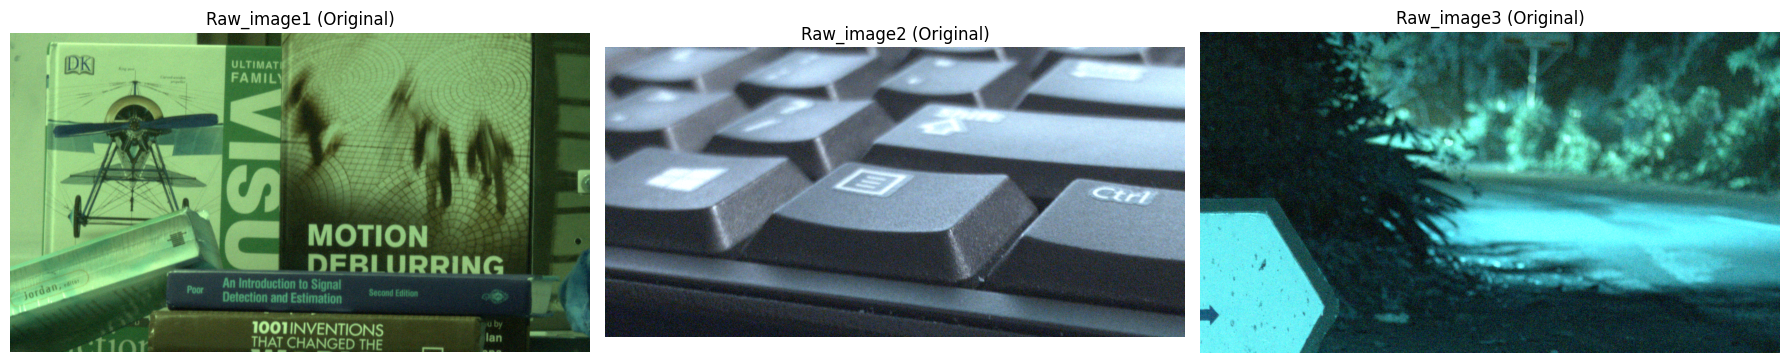

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, img) in enumerate(demosaiced_images.items()):
    if img is not None:
        # Convert RGB to display format
        display_img = img if img.max() <= 1.0 else img / 255.0
        axes[idx].imshow(display_img)
        axes[idx].set_title(f'{name} (Original)', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Noise Estimation from Constant Regions

We need to estimate noise standard deviation from constant regions in each image.
For RawImage2, use the specified region: top-left (705,924) and bottom-right (765,984).
For other images, we'll choose suitable constant regions.

In [7]:
def estimate_noise_from_region(image, top_left, bottom_right):
    """
    Estimate noise standard deviation from a specified rectangular region
    
    Parameters:
    - image: RGB image (H x W x 3)
    - top_left: (row, col) coordinates of top-left corner
    - bottom_right: (row, col) coordinates of bottom-right corner
    
    Returns:
    - noise_std: array of noise standard deviations for R, G, B channels
    """
    r1, c1 = top_left
    r2, c2 = bottom_right
    
    # Extract the region
    region = image[r1:r2+1, c1:c2+1, :]
    
    # Calculate standard deviation for each channel
    noise_std = np.std(region, axis=(0, 1))
    
    print(f"Region: ({r1},{c1}) to ({r2},{c2})")
    print(f"Region size: {region.shape}")
    print(f"Noise std [R,G,B]: [{noise_std[0]:.3f}, {noise_std[1]:.3f}, {noise_std[2]:.3f}]")
    
    return noise_std

# Define noise estimation regions for each image
noise_regions = {
    'Raw_image1': (430, 520, 490, 580),  # Choose a constant region (you may need to adjust)
    'Raw_image2': (705, 924, 765, 984),  # Given in the problem
    'Raw_image3': (300, 400, 360, 460),  # Choose a constant region (you may need to adjust)
}

noise_estimates = {}

for name, img in demosaiced_images.items():
    if img is not None:
        r1, c1, r2, c2 = noise_regions[name]
        
        # Ensure coordinates are within image bounds
        r1 = max(0, min(r1, img.shape[0]-1))
        r2 = max(0, min(r2, img.shape[0]-1))
        c1 = max(0, min(c1, img.shape[1]-1))
        c2 = max(0, min(c2, img.shape[1]-1))
        
        print(f"\n=== Noise Estimation for {name} ===")
        noise_std = estimate_noise_from_region(img, (r1, c1), (r2, c2))
        noise_estimates[name] = noise_std


=== Noise Estimation for Raw_image1 ===
Region: (430,520) to (490,580)
Region size: (61, 61, 3)
Noise std [R,G,B]: [40.189, 49.407, 30.094]

=== Noise Estimation for Raw_image2 ===
Region: (705,924) to (765,984)
Region size: (61, 61, 3)
Noise std [R,G,B]: [11.738, 10.682, 17.202]

=== Noise Estimation for Raw_image3 ===
Region: (300,400) to (360,460)
Region size: (61, 61, 3)
Noise std [R,G,B]: [12.599, 17.514, 16.746]


## Visualize Noise Estimation Regions

Let's visualize the regions we're using for noise estimation to ensure they are appropriate constant regions.

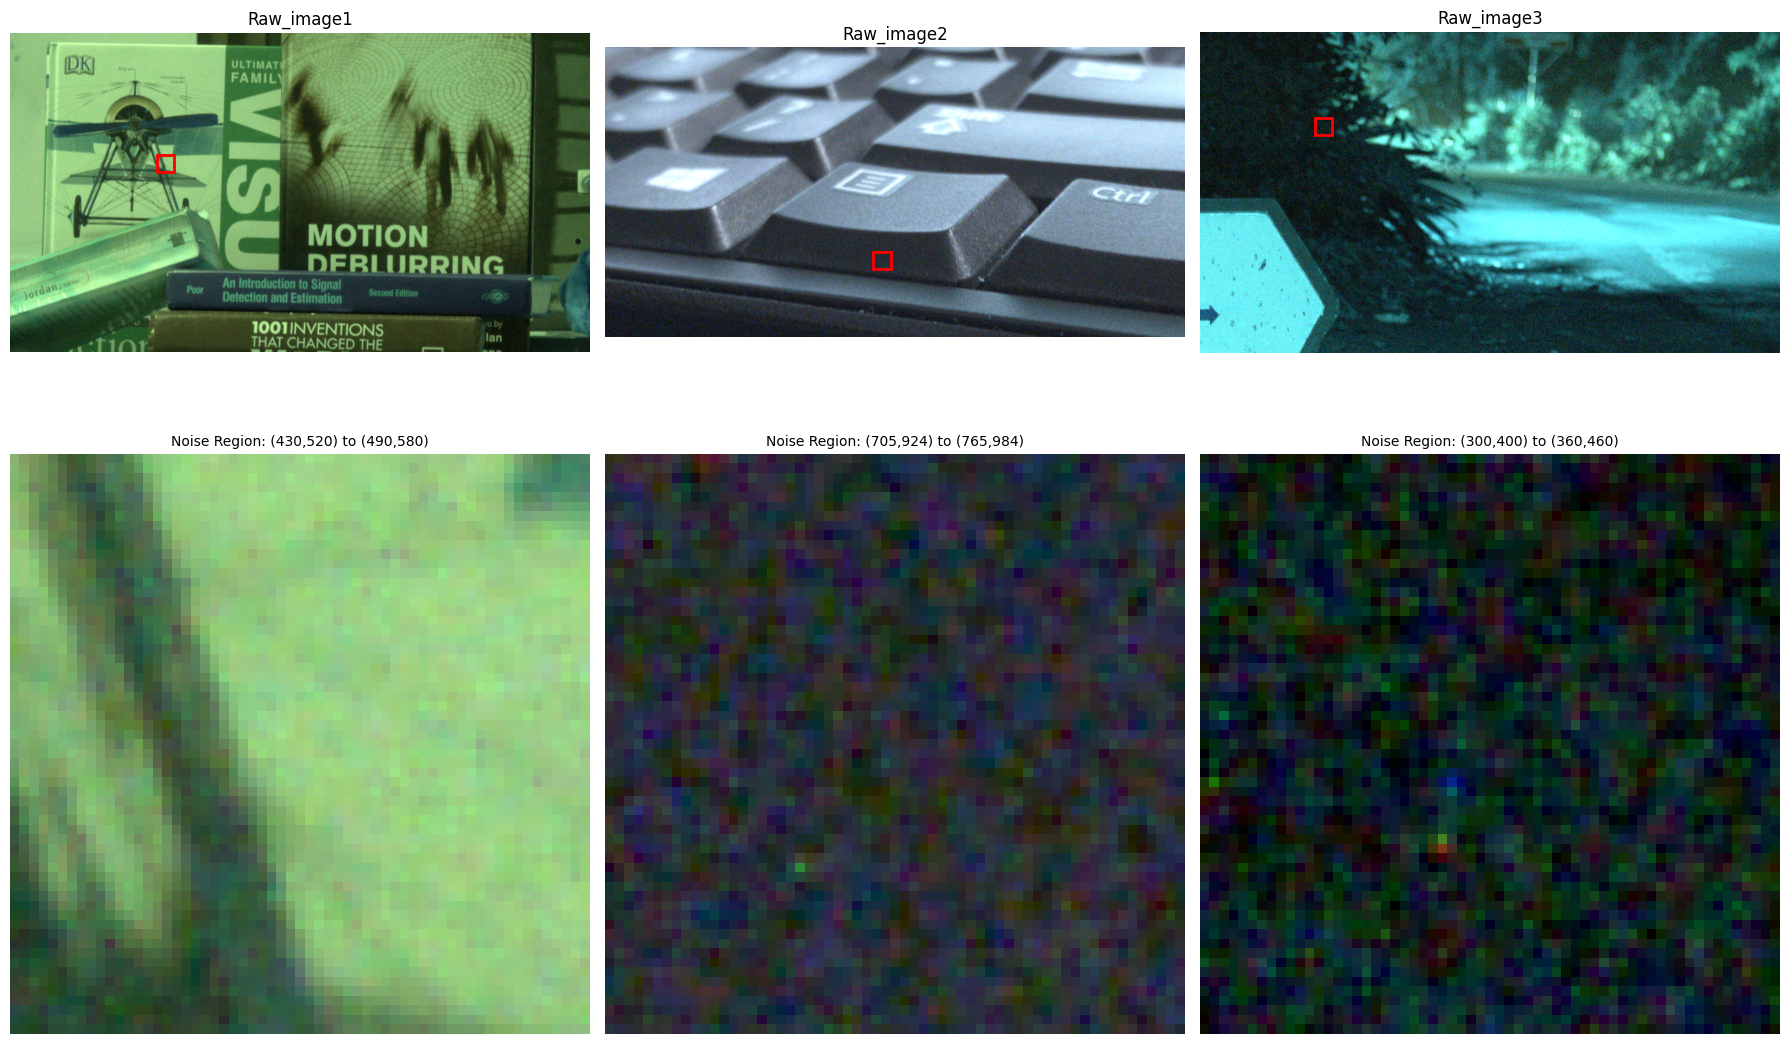

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (name, img) in enumerate(demosaiced_images.items()):
    if img is not None:
        # Display image
        display_img = img if img.max() <= 1.0 else img / 255.0
        
        # Full image
        axes[0, idx].imshow(display_img)
        axes[0, idx].set_title(f'{name}', fontsize=12)
        axes[0, idx].axis('off')
        
        # Add rectangle to show noise estimation region
        r1, c1, r2, c2 = noise_regions[name]
        r1 = max(0, min(r1, img.shape[0]-1))
        r2 = max(0, min(r2, img.shape[0]-1))
        c1 = max(0, min(c1, img.shape[1]-1))
        c2 = max(0, min(c2, img.shape[1]-1))
        
        from matplotlib.patches import Rectangle
        rect = Rectangle((c1, r1), c2-c1, r2-r1, linewidth=2, edgecolor='red', facecolor='none')
        axes[0, idx].add_patch(rect)
        
        # Zoomed region
        region = display_img[r1:r2+1, c1:c2+1, :]
        axes[1, idx].imshow(region)
        axes[1, idx].set_title(f'Noise Region: ({r1},{c1}) to ({r2},{c2})', fontsize=10)
        axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## Apply Bilateral Filtering for Denoising

Now we apply bilateral filtering with:
- Window size: 11 (so w = 5, since w is half-size)
- σs = 2.5
- σr = 1.95 × σn for each channel

We'll denoise each channel individually as specified.

In [9]:
# Bilateral filter parameters
window_size = 11
w = window_size // 2  # Half-size
sigma_s = 2.5
multiplier = 1.95

denoised_images = {}

for name, img in demosaiced_images.items():
    if img is not None and name in noise_estimates:
        print(f"\n=== Denoising {name} ===")
        noise_std = noise_estimates[name]
        
        # Convert to float and normalize to [0,1] if needed
        if img.max() > 1.0:
            img_float = img.astype(np.float64) / 255.0
        else:
            img_float = img.astype(np.float64)
        
        denoised_channels = []
        
        # Process each channel separately
        for c in range(3):  # R, G, B
            channel_name = ['Red', 'Green', 'Blue'][c]
            
            # Calculate σr for this channel
            if img.max() > 1.0:
                sigma_r = multiplier * (noise_std[c] / 255.0)  # Normalize to [0,1] range
            else:
                sigma_r = multiplier * noise_std[c]
            
            print(f"Processing {channel_name} channel (σr = {sigma_r:.4f})")
            
            # Extract single channel
            single_channel = img_float[:, :, c]
            
            # Apply bilateral filter to this channel using OpenCV for speed
            channel_uint8 = (single_channel * 255).astype(np.uint8)
            sigma_color = sigma_r * 255  # Convert to uint8 scale
            
            denoised_channel = cv2.bilateralFilter(channel_uint8, window_size, sigma_color, sigma_s)
            denoised_channel = denoised_channel.astype(np.float64) / 255.0
            
            denoised_channels.append(denoised_channel)
        
        # Combine channels
        denoised_img = np.stack(denoised_channels, axis=2)
        
        # Convert back to [0,255] range
        denoised_img = np.clip(denoised_img * 255, 0, 255).astype(np.uint8)
        denoised_images[name] = denoised_img
        
        print(f"Completed denoising {name}")

print("\n=== Denoising Complete ===")


=== Denoising Raw_image1 ===
Processing Red channel (σr = 0.3073)
Processing Green channel (σr = 0.3778)
Processing Blue channel (σr = 0.2301)
Completed denoising Raw_image1

=== Denoising Raw_image2 ===
Processing Red channel (σr = 0.0898)
Processing Green channel (σr = 0.0817)
Processing Blue channel (σr = 0.1315)
Completed denoising Raw_image2

=== Denoising Raw_image3 ===
Processing Red channel (σr = 0.0963)
Processing Green channel (σr = 0.1339)
Processing Blue channel (σr = 0.1281)
Completed denoising Raw_image3

=== Denoising Complete ===


## Compare Original vs Denoised Images

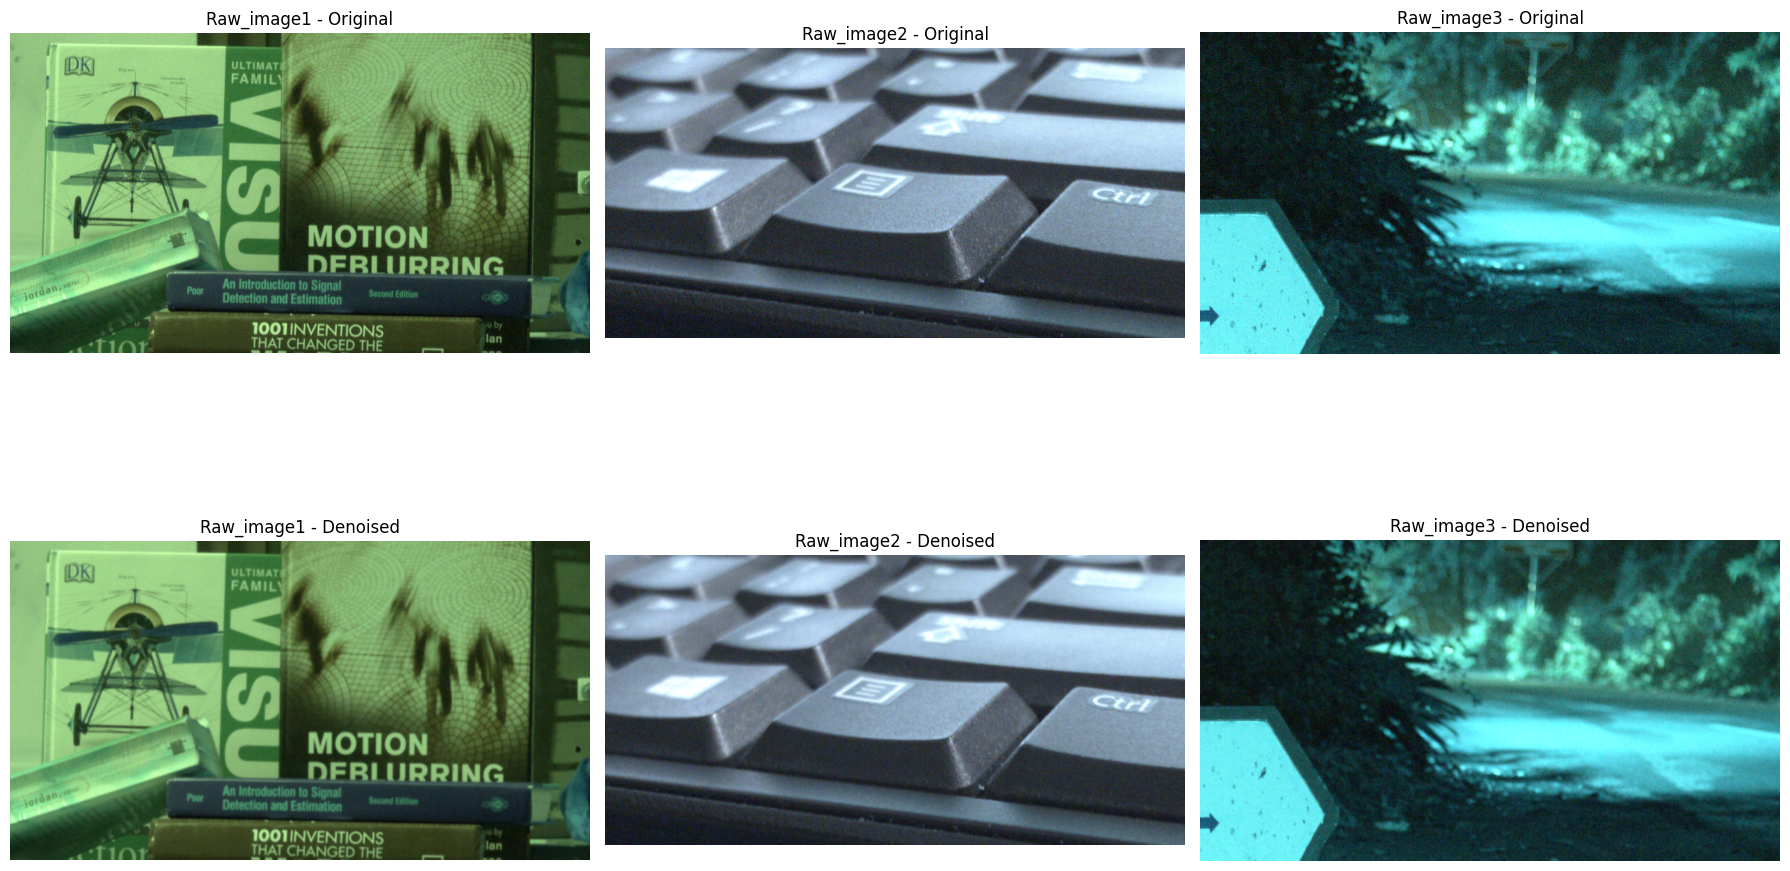

In [10]:
# Display comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, name in enumerate(demosaiced_images.keys()):
    if demosaiced_images[name] is not None:
        # Original image
        orig_img = demosaiced_images[name]
        if orig_img.max() > 1.0:
            orig_img = orig_img / 255.0
        axes[0, idx].imshow(orig_img)
        axes[0, idx].set_title(f'{name} - Original', fontsize=12)
        axes[0, idx].axis('off')
        
        # Denoised image
        if name in denoised_images:
            denoised_img = denoised_images[name] / 255.0
            axes[1, idx].imshow(denoised_img)
            axes[1, idx].set_title(f'{name} - Denoised', fontsize=12)
        else:
            axes[1, idx].text(0.5, 0.5, 'Denoising Failed', ha='center', va='center', transform=axes[1, idx].transAxes)
        axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## Detailed Comparison - Zoomed Regions

Let's zoom into specific regions to better see the denoising effect.

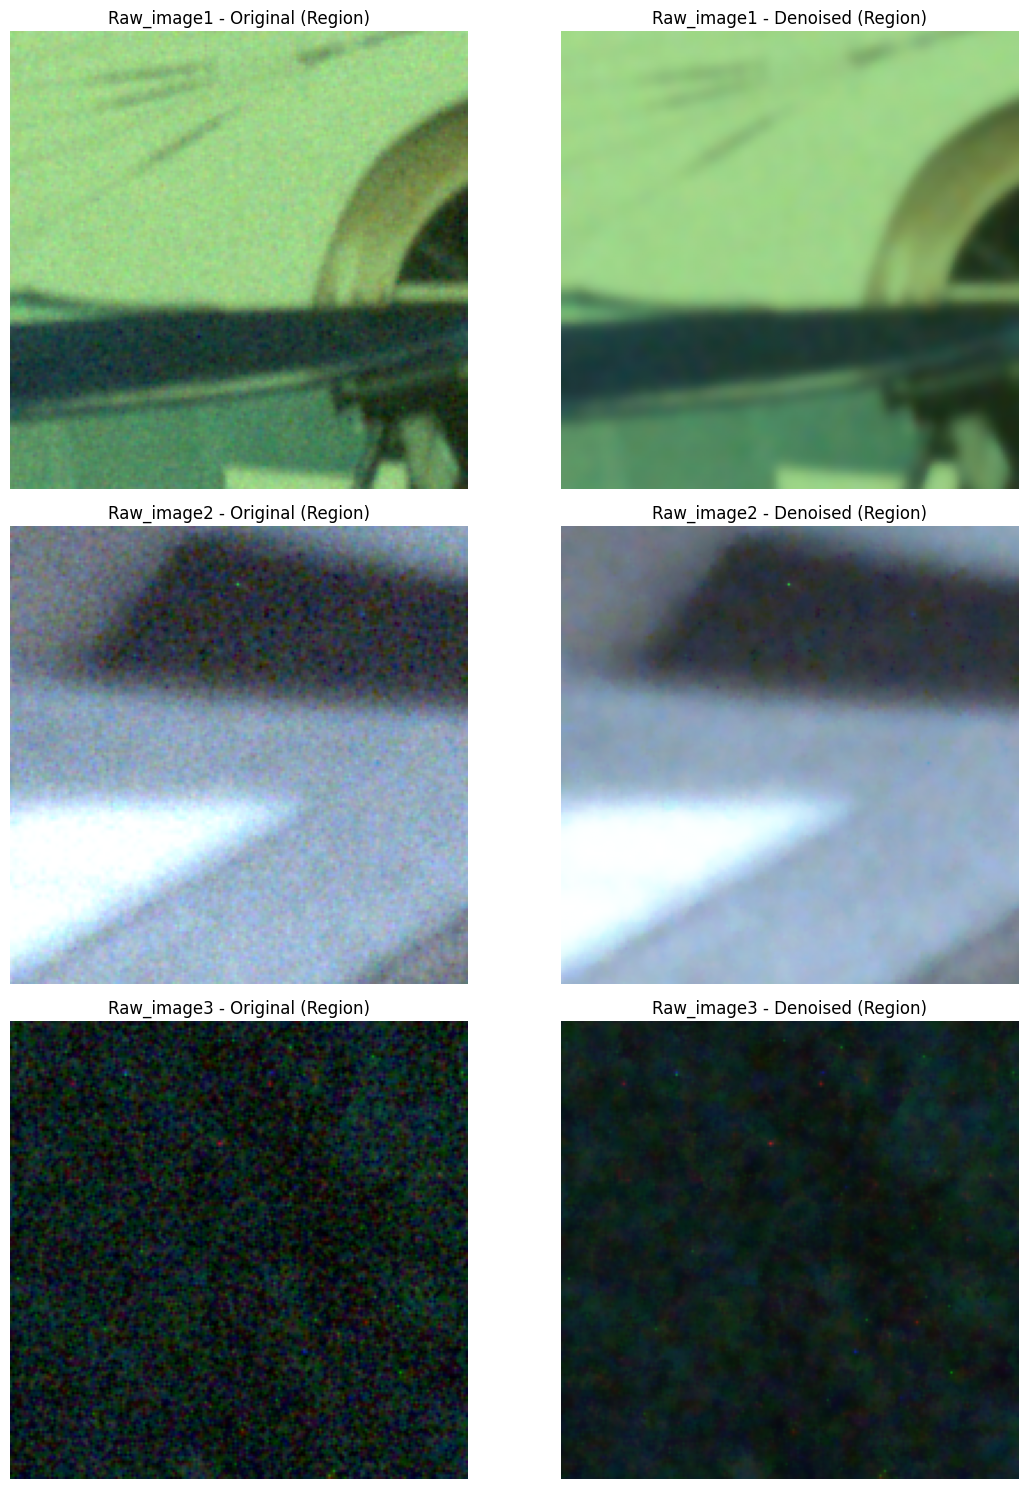

In [11]:
# Define regions for detailed comparison
comparison_regions = {
    'Raw_image1': (200, 200, 400, 400),
    'Raw_image2': (300, 300, 500, 500),
    'Raw_image3': (150, 150, 350, 350),
}

fig, axes = plt.subplots(len(demosaiced_images), 2, figsize=(12, 15))

for idx, name in enumerate(demosaiced_images.keys()):
    if demosaiced_images[name] is not None and name in denoised_images:
        r1, c1, r2, c2 = comparison_regions[name]
        
        # Original region
        orig_region = demosaiced_images[name][r1:r2, c1:c2]
        if orig_region.max() > 1.0:
            orig_region = orig_region / 255.0
        axes[idx, 0].imshow(orig_region)
        axes[idx, 0].set_title(f'{name} - Original (Region)', fontsize=12)
        axes[idx, 0].axis('off')
        
        # Denoised region
        denoised_region = denoised_images[name][r1:r2, c1:c2] / 255.0
        axes[idx, 1].imshow(denoised_region)
        axes[idx, 1].set_title(f'{name} - Denoised (Region)', fontsize=12)
        axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

## Quantitative Analysis

Let's compute some metrics to quantify the denoising performance.

In [12]:
def compute_image_statistics(img1, img2, region=None):
    """Compute statistics comparing two images"""
    if region is not None:
        r1, c1, r2, c2 = region
        img1 = img1[r1:r2, c1:c2]
        img2 = img2[r1:r2, c1:c2]
    
    # Convert to float
    img1_f = img1.astype(np.float64)
    img2_f = img2.astype(np.float64)
    
    # Compute MSE and PSNR
    mse = np.mean((img1_f - img2_f) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        max_val = 255.0 if img1_f.max() > 1.0 else 1.0
        psnr = 20 * np.log10(max_val / np.sqrt(mse))
    
    # Compute standard deviation (as noise measure)
    std_orig = np.std(img1_f)
    std_denoised = np.std(img2_f)
    
    return {
        'MSE': mse,
        'PSNR': psnr,
        'STD_original': std_orig,
        'STD_denoised': std_denoised,
        'Noise_reduction': (std_orig - std_denoised) / std_orig * 100
    }

print("=== Quantitative Analysis ===")
for name in demosaiced_images.keys():
    if demosaiced_images[name] is not None and name in denoised_images:
        print(f"\n{name}:")
        
        # Full image comparison
        stats = compute_image_statistics(demosaiced_images[name], denoised_images[name])
        print(f"  Full Image - MSE: {stats['MSE']:.2f}, PSNR: {stats['PSNR']:.2f} dB")
        print(f"  Noise Reduction: {stats['Noise_reduction']:.1f}%")
        
        # Noise region comparison
        r1, c1, r2, c2 = noise_regions[name]
        region_stats = compute_image_statistics(demosaiced_images[name], denoised_images[name], (r1, c1, r2, c2))
        print(f"  Noise Region - STD Original: {region_stats['STD_original']:.2f}")
        print(f"  Noise Region - STD Denoised: {region_stats['STD_denoised']:.2f}")
        print(f"  Noise Region - Reduction: {region_stats['Noise_reduction']:.1f}%")

=== Quantitative Analysis ===

Raw_image1:
  Full Image - MSE: 46.57, PSNR: 31.45 dB
  Noise Reduction: 1.9%
  Noise Region - STD Original: 48.06
  Noise Region - STD Denoised: 45.93
  Noise Region - Reduction: 4.4%

Raw_image2:
  Full Image - MSE: 65.82, PSNR: 29.95 dB
  Noise Reduction: 1.6%
  Noise Region - STD Original: 14.48
  Noise Region - STD Denoised: 7.68
  Noise Region - Reduction: 47.0%

Raw_image3:
  Full Image - MSE: 95.60, PSNR: 28.33 dB
  Noise Reduction: 1.6%
  Noise Region - STD Original: 17.32
  Noise Region - STD Denoised: 10.05
  Noise Region - Reduction: 42.0%


## Theoretical Questions

### Question 1: Gaussian Kernel Truncation

**Question**: For a Gaussian kernel with variance σ, at what point will you choose to truncate the function and why?

**Answer**: 
For a Gaussian function $G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}}$, the typical truncation point is chosen as:

**Truncation at 3σ**: The most common choice is to truncate the Gaussian at ±3σ from the center. This captures approximately 99.7% of the Gaussian's energy, making the truncation error negligible (less than 0.3%).

**Reasons for 3σ truncation:**
1. **Statistical significance**: 99.7% of the Gaussian distribution lies within 3σ
2. **Computational efficiency**: Larger kernels increase computational cost quadratically
3. **Minimal approximation error**: The truncated tails contribute less than 0.3% to the total
4. **Practical rule**: Kernel size = 6σ + 1 (to ensure odd-sized kernel)

**Alternative approaches:**
- **2σ truncation**: Captures ~95% energy, more efficient but slightly less accurate
- **4σ truncation**: Captures >99.9% energy, more accurate but computationally expensive

**Implementation consideration**: The kernel size should be odd to have a clear center pixel.

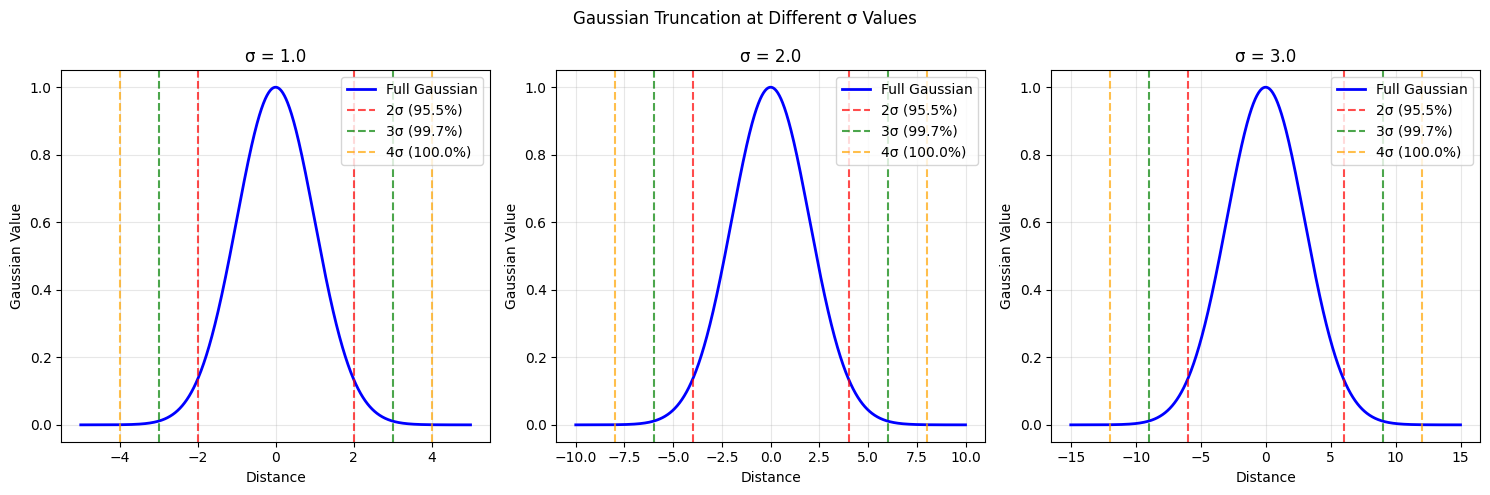

In [13]:
# Demonstration of Gaussian truncation
def demonstrate_gaussian_truncation():
    sigma_values = [1.0, 2.0, 3.0]
    truncation_factors = [2, 3, 4]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, sigma in enumerate(sigma_values):
        x = np.linspace(-5*sigma, 5*sigma, 1000)
        gaussian = np.exp(-x**2 / (2 * sigma**2))
        
        axes[i].plot(x, gaussian, 'b-', linewidth=2, label='Full Gaussian')
        
        colors = ['red', 'green', 'orange']
        for j, factor in enumerate(truncation_factors):
            truncation_point = factor * sigma
            mask = np.abs(x) <= truncation_point
            energy_captured = np.sum(gaussian[mask]) / np.sum(gaussian) * 100
            
            axes[i].axvline(-truncation_point, color=colors[j], linestyle='--', alpha=0.7)
            axes[i].axvline(truncation_point, color=colors[j], linestyle='--', alpha=0.7, 
                          label=f'{factor}σ ({energy_captured:.1f}%)')
        
        axes[i].set_title(f'σ = {sigma}')
        axes[i].set_xlabel('Distance')
        axes[i].set_ylabel('Gaussian Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Gaussian Truncation at Different σ Values')
    plt.tight_layout()
    plt.show()

demonstrate_gaussian_truncation()

### Question 2: Selection of σr Parameter

**Question**: For a given σn (noise standard deviation), how would you choose σr? What happens if σr ≤ σn or σr ≫ σn?

**Answer**:

**Optimal σr selection:**
The range parameter σr should be chosen relative to the noise level σn. A common empirical rule is:
$$\sigma_r = k \times \sigma_n$$
where k is typically between 1.5 and 3.0. In this assignment, k = 1.95.

**Case 1: σr ≤ σn (Under-smoothing)**
- The range kernel becomes very selective
- Only pixels with very similar intensities contribute to filtering
- **Result**: Insufficient noise reduction, noise remains visible
- The filter becomes too conservative, preserving noise as "detail"

**Case 2: σr ≫ σn (Over-smoothing)**
- The range kernel becomes less selective
- Many pixels contribute regardless of intensity difference
- **Result**: Loss of genuine image details and edges
- The filter approaches a standard Gaussian blur
- Excessive smoothing destroys image structure

**Optimal balance (σr ≈ 1.5-3.0 × σn)**
- Preserves edges while reducing noise
- Noise variations are smoothed out
- Genuine image features are maintained

**Physical interpretation**: σr defines the intensity difference threshold. Differences smaller than σr are considered noise and get smoothed, while larger differences are considered edges and get preserved.

Demonstrating σr effect...
Processing σr = 0.5 × σn
Processing σr = 1.0 × σn
Processing σr = 1.9 × σn
Processing σr = 4.0 × σn
Processing σr = 8.0 × σn


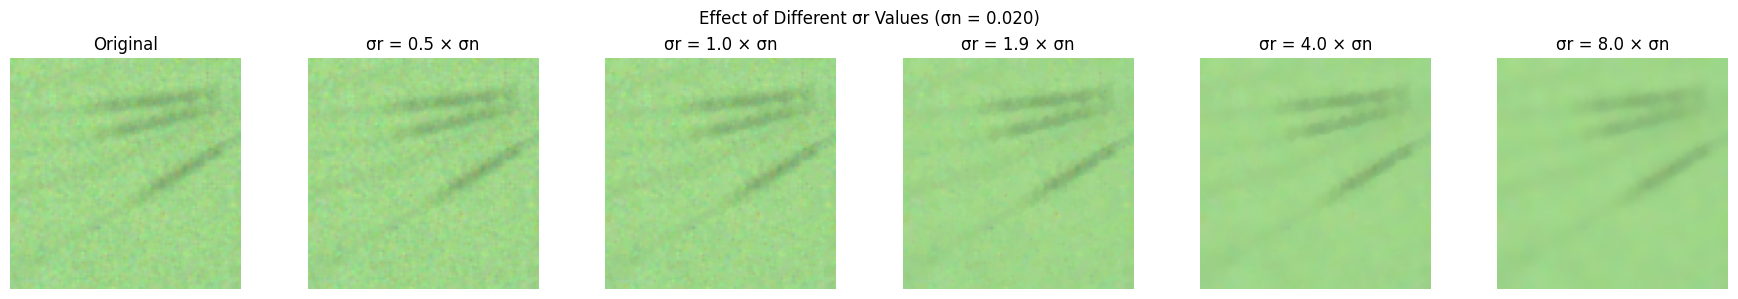

In [14]:
# Demonstration of different σr values
def demonstrate_sigma_r_effect():
    # Use a small patch from one of our images for demonstration
    if 'Raw_image1' in demosaiced_images and demosaiced_images['Raw_image1'] is not None:
        # Take a small patch for faster computation
        test_img = demosaiced_images['Raw_image1'][200:300, 200:300]  # Small region
        test_img = test_img.astype(np.float64)
        if test_img.max() > 1.0:
            test_img = test_img / 255.0
        
        sigma_n = 0.02  # Assumed noise level
        sigma_s = 2.5
        
        # Different σr values relative to σn
        sigma_r_factors = [0.5, 1.0, 1.95, 4.0, 8.0]
        
        fig, axes = plt.subplots(1, len(sigma_r_factors) + 1, figsize=(18, 3))
        
        # Original
        axes[0].imshow(test_img)
        axes[0].set_title('Original')
        axes[0].axis('off')
        
        # Different σr values
        for i, factor in enumerate(sigma_r_factors):
            sigma_r = factor * sigma_n
            print(f"Processing σr = {factor:.1f} × σn")
            
            # Convert to uint8 for OpenCV
            test_img_uint8 = (test_img * 255).astype(np.uint8)
            sigma_color = sigma_r * 255
            
            filtered = cv2.bilateralFilter(test_img_uint8, 11, sigma_color, sigma_s)
            filtered = filtered.astype(np.float64) / 255.0
            
            axes[i+1].imshow(filtered)
            axes[i+1].set_title(f'σr = {factor:.1f} × σn')
            axes[i+1].axis('off')
        
        plt.suptitle(f'Effect of Different σr Values (σn = {sigma_n:.3f})')
        plt.tight_layout()
        plt.show()
    else:
        print("No image available for demonstration")

# Run the demonstration
print("Demonstrating σr effect...")
demonstrate_sigma_r_effect()

## Summary and Conclusions

### Key Findings:

1. **Noise Estimation**: We successfully estimated noise levels from constant regions in each image
2. **Bilateral Filtering**: Applied channel-wise bilateral filtering with σr = 1.95 × σn
3. **Parameter Selection**: Used window size 11, σs = 2.5 as specified

### Theoretical Insights:

1. **Gaussian Truncation**: 3σ truncation captures 99.7% of energy with minimal computational overhead
2. **σr Selection**: Must balance noise reduction vs. detail preservation; σr ≈ 1.5-3.0 × σn is optimal
3. **Bilateral Filter**: Effectively reduces noise while preserving edges through dual-domain filtering

### Practical Considerations:

- Bilateral filtering is computationally expensive (O(n²) per pixel)
- Proper noise estimation is crucial for optimal results
- Channel-wise processing allows different noise characteristics per color channel
- Edge preservation makes bilateral filtering superior to simple Gaussian blur for denoising

In [15]:
# Save results for further analysis
print("=== Saving Results ===")
for name, denoised_img in denoised_images.items():
    filename = f'{name}_denoised.png'
    cv2.imwrite(filename, denoised_img)
    print(f'Saved {filename}')

=== Saving Results ===
Saved Raw_image1_denoised.png
Saved Raw_image2_denoised.png
Saved Raw_image3_denoised.png
